In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt

In [ ]:
time = np.arange(1,1441)
offset = 10

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    if type(series) == int:
      series = series*np.ones(len(time))

    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def trend(time, slope = 0):
  
  series = slope * time

  return series

In [ ]:
np.random.randint(10,20)

12

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


In [ ]:
series = offset + trend(time,slope=0.0002) + seasonality(time,period=365,amplitude=0.1) 

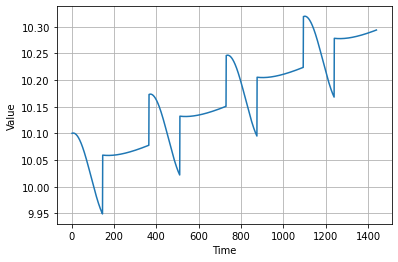

In [ ]:
plot_series(time,series)

In [297]:
def noise(time,sigma=.025,mu=0):
  return np.random.randn(len(time))*sigma + mu

In [ ]:
series = offset + trend(time,slope=0.0002) + seasonality(time,period=365,amplitude=0.1) + noise(time)

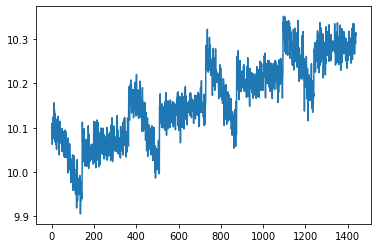

In [ ]:
plt.plot(series)

In [ ]:
def autocorrelation(time, amplitude,sigma=1,mu=0,initial_offset=None):
    rho1 = 0.5
    rho2 = -0.1
    #rho3 = 0.2
    #rho4 = -0.3
    ar = np.random.randn(len(time) + 50)*sigma + mu
    if initial_offset is not None:
      ar[:50] = initial_offset
    for step in range(50, len(time) + 50):
        ar[step] += rho1 * ar[step - 50]
        ar[step] += rho2 * ar[step - 33]
        #ar[step] += rho3 * ar[step - 40]
        #ar[step] += rho4 * ar[step - 5]

    return ar[50:] * amplitude

In [ ]:
series =  offset + trend(time,slope=0.0002) + seasonality(time,period=365,amplitude=0.1) + noise(time) + autocorrelation(time,1)

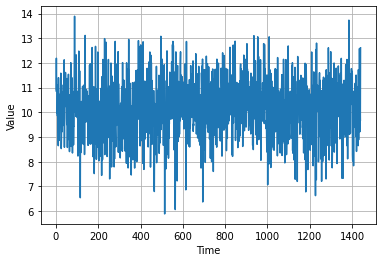

In [ ]:
plot_series(time,series)

# ACF Plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

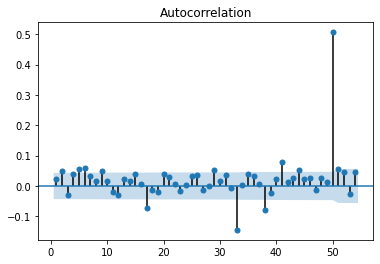

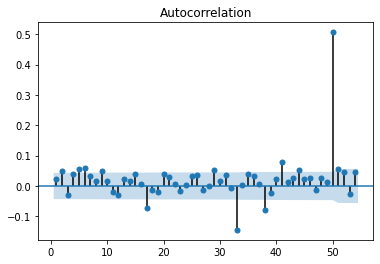

In [ ]:
plot_acf(series,lags=np.arange(1,55),alpha=0.1)

# Smoothing

In [ ]:
ts_df = pd.DataFrame({'time':time,'value':series})

In [ ]:
ts_df.head()

,time,value
0,1,10.864929
1,2,12.191276
2,3,10.903164
3,4,10.898228
4,5,9.961111


In [ ]:
ts_df.value.rolling(10).mean()

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
1435    10.383756
1436    10.409765
1437    10.365444
1438    10.465993
1439    10.554784
Name: value, Length: 1440, dtype: float64

In [ ]:
ts_df['roll_10'] = ts_df.value.rolling(10).mean()
#ts_df['roll_20'] = ts_df.value.rolling(20).mean()

In [ ]:
alt.Chart(ts_df).mark_line().encode(x='time:Q',y='value:Q') + alt.Chart(ts_df).mark_line(color='orange').encode(x='time:Q',y='roll_10:Q') #+ alt.Chart(ts_df).mark_line(color='red').encode(x='time:Q',y='roll_20:Q')

alt.LayerChart(...)

In [ ]:
ts_df['exp_roll_100'] = ts_df.value.rolling(window=100,win_type='exponential').mean(tau=10)

In [ ]:
alt.Chart(ts_df).mark_line().encode(x='time:Q',y='value:Q') + alt.Chart(ts_df).mark_line(color='orange').encode(x='time:Q',y='exp_roll_100:Q')

alt.LayerChart(...)

# Differencing

In [280]:
series =  offset + trend(time,slope=0.0002) + seasonality(time,period=365,amplitude=0.1) + noise(time) + autocorrelation(time,1,sigma=0.025)

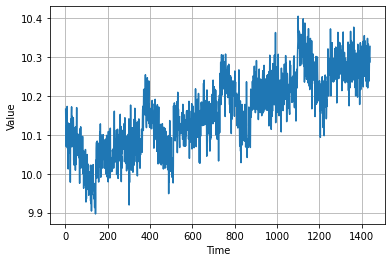

In [281]:
plot_series(time,series)

In [282]:
diff = series[365:] - series[:-365]
diff_t = time[365:]

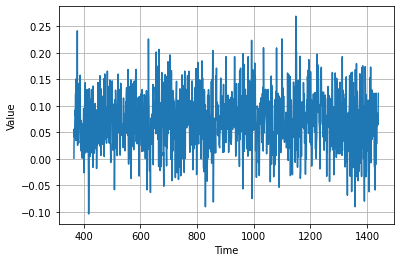

In [283]:
plot_series(diff_t,diff)

In [285]:
diff_df = pd.DataFrame({'time':diff_t,'value':diff})

In [286]:
diff_df['roll_10'] = diff_df.value.rolling(10).mean()
diff_df['exp_roll_10'] = diff_df.value.rolling(10,win_type='exponential').mean(tau=10)

In [291]:
alt.Chart(diff_df).mark_line().encode(x='time:Q',y='value:Q') + alt.Chart(diff_df).mark_line(color='orange').encode(x='time:Q',y='roll_10:Q') 

alt.LayerChart(...)

# Forecast Examples

In [319]:
# Create the series
series = offset + trend(time, slope=0.01) + seasonality(time, period=365, amplitude=10)
# Update with noise
series += noise(time,sigma=2)

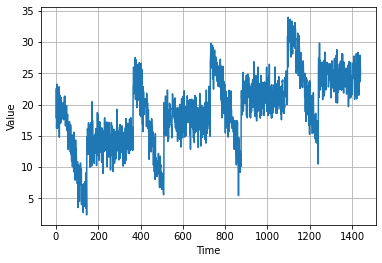

In [320]:
plot_series(time,series)

In [321]:
split = 1000
time_train,time_val = time[:split],time[split:]
series_train,series_val = series[:split],series[split:]

### Naive

In [322]:
naive_forecast = series[split - 1:-1]

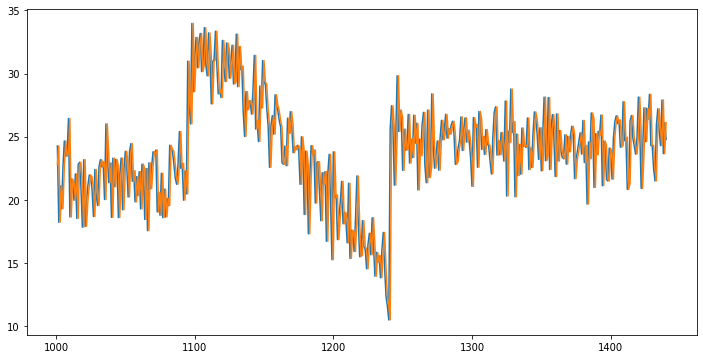

In [326]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,series_val)
ax.plot(time_val,naive_forecast)

In [327]:
from sklearn.metrics import mean_squared_error

In [330]:
rmse_score = np.sqrt(mean_squared_error(series_val,naive_forecast))
print(f'Naive Forecast RMSE: {rmse_score}')

Naive Forecast RMSE: 2.8822042087391804


### Moving Avg Forecast

In [448]:
def ma(series,window,split=split):
  df = pd.DataFrame(series,columns=['ts'])
  ma = df.ts.shift(1).rolling(window).mean().values
  return ma[split:]

def ewma(series,window,tau):
  df = pd.DataFrame(series,columns=['ts'])
  ewma = df.ts.shift(1).rolling(window,win_type='exponential').mean(tau=tau).values
  return ewma[split:]

In [469]:
ma_forecast = ma(series,30)

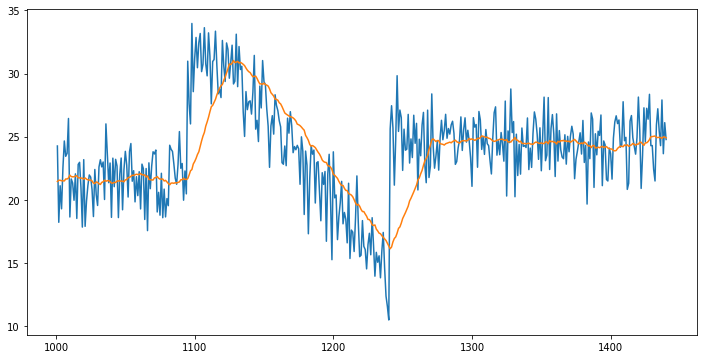

In [470]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,series_val)
ax.plot(time_val,ma_forecast)

In [471]:
rmse_score = np.sqrt(mean_squared_error(series_val,ma_forecast))
print(f'MA Forecast RMSE: {rmse_score}')

MA Forecast RMSE: 3.02079792249754


In [455]:
ewma_forecast = ewma(series,10,1)

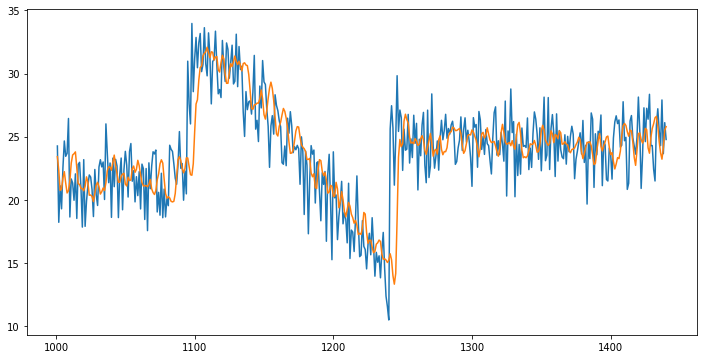

In [456]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,series_val)
ax.plot(time_val,ewma_forecast)

In [457]:
rmse_score = np.sqrt(mean_squared_error(series_val,ewma_forecast))
print(f'EWMA Forecast RMSE: {rmse_score}')

EWMA Forecast RMSE: 2.6519891080012985


### Differencing

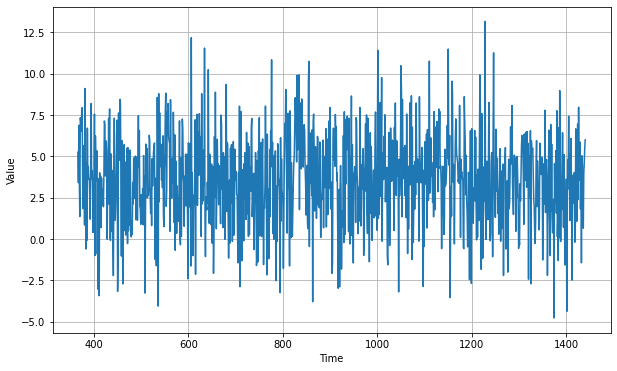

In [402]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

In [461]:
diff_ma_forecast = ma(diff_series,30,split=split-365)

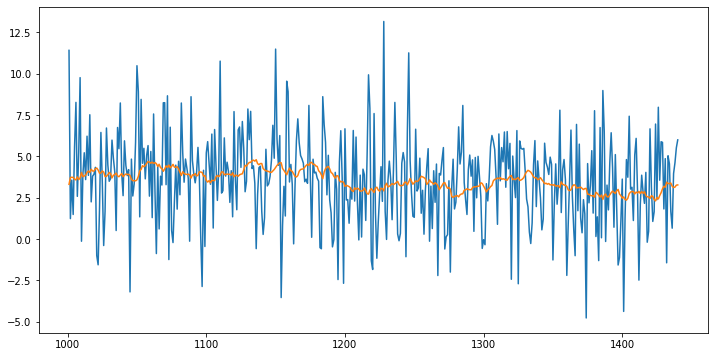

In [462]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,diff_series[split-365:])
ax.plot(time_val,diff_ma_forecast)

In [463]:
subtracted = series[:-365]
subtracted.shape

(1075,)

In [464]:
subtracted_val = series[split-365:-365]

In [465]:
subtracted_val.shape

(440,)

In [466]:
diff_ma_corrected = diff_ma_forecast + subtracted_val

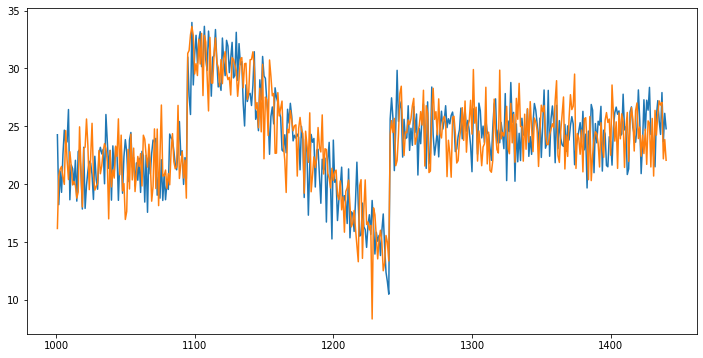

In [467]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,series_val)
ax.plot(time_val,diff_ma_corrected)

In [468]:
rmse_score = np.sqrt(mean_squared_error(series_val,diff_ma_corrected))
print(f'Diff M.Avg. Forecast RMSE: {rmse_score}')

Diff M.Avg. Forecast RMSE: 2.7956079196502492


## Still noisy. 😔 Any ideas why?


In [458]:
subtracted_ma = ma(series[:-365],window=10,split=split-365)
diff_ma_corrected_2 = diff_ma_forecast + subtracted_ma

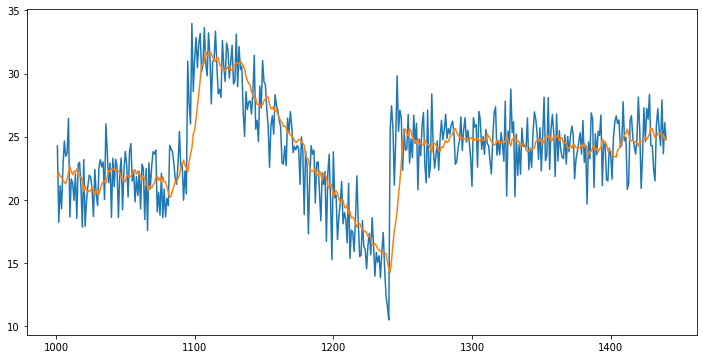

In [459]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(time_val,series_val)
ax.plot(time_val,diff_ma_corrected_2)

In [460]:
rmse_score = np.sqrt(mean_squared_error(series_val,diff_ma_corrected_2))
print(f'Diff M.Avg. Forecast RMSE: {rmse_score}')

Diff M.Avg. Forecast RMSE: 2.4826928149612524
